In [69]:
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

## Loading the dataset

In [70]:
data_path = '../data/'
mnist = datasets.MNIST(data_path, download=True)
to_tensor = transforms.ToTensor()

## Viewing the content of a sample

3 - three
torch.Size([1, 28, 28])


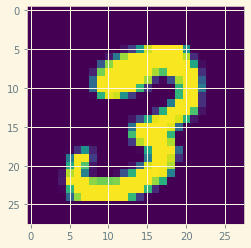

In [71]:
img, label = mnist[12345]
plt.imshow(img)
print(mnist.classes[label])
img_t = to_tensor(img)
print(img_t.shape)

## Computing mean and standard deviation to normalize the dataset

In [72]:
imgs = torch.stack([to_tensor(img_t) for img_t, _ in mnist], dim=3)#%%
imgs.shape

torch.Size([1, 28, 28, 60000])

In [73]:
m = imgs.view(1,-1).mean(dim=1).item()
s  = imgs.view(1,-1).std(dim=1).item()
m, s

(0.13066332042217255, 0.30810782313346863)

## Specifying the model

Inspired from many examples published on github (I can't get back to the one I choose...)

In [74]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class Net(nn.Module):
    # init the layers of the model
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    # glue the layers together with forward...
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# model (and auxiliary functions) instantiation
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

## Implementing the train and test routines

In [75]:
import torch.utils.data as torchdata
from torch import cuda

def train_model(model, optimizer,
                  loss_fn, train_data, device, n_epochs=10, batch_size=64):

    model.to(device)
    loss_fn.to(device)
    train_loader = torchdata.DataLoader(train_data,
                               batch_size=batch_size,
                               shuffle=True,
                               pin_memory=(device.type == 'cuda'))

    train_items_count = len(train_loader) # number of batches in the train dataset

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        # process a batch of batch_size images at each iteration
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device = device), labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        avg_loss = loss_train / train_items_count
        yield {'epoch': epoch, 'avg_train_loss':avg_loss}

def test_model(model, device, validation_data, batch_size=256):
    loss = 0
    correct = 0
    validation_loader = torchdata.DataLoader(validation_data,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    pin_memory=(device.type == 'cuda'))
    n_items = len(validation_loader.dataset)
    model.eval()
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = loss / n_items
    return {'avg_test_loss': avg_loss, 'test_correct_items': correct, 'test_items': n_items}

## Configuring the data loaders

In [76]:
mnist_train = datasets.MNIST(data_path, train=True, download=True,
                             transform=transforms.Compose(
                                 [transforms.ToTensor(),
                                  transforms.Normalize(m,s)]))

mnist_validate = datasets.MNIST(data_path, train=False, download=True,
                             transform=transforms.Compose(
                                 [transforms.ToTensor(),
                                  transforms.Normalize(m,s)]))

## Training the model

In [77]:
device = torch.device('cuda' if cuda.is_available() else 'cpu')
train_loop = train_model(model, optimizer, loss_fn, mnist_train, device, n_epochs=20)
perf_history = []
for train_data in train_loop:
    test_data = test_model(model, device, mnist_validate)
    perf_data = {**train_data, **test_data}
    print(perf_data)
    perf_history.append(perf_data)

{'epoch': 1, 'avg_train_loss': 0.5242107015953008, 'avg_test_loss': 0.21380535331964493, 'test_correct_items': 9326, 'test_items': 10000}
{'epoch': 2, 'avg_train_loss': 0.15535886513629257, 'avg_test_loss': 0.1258148792386055, 'test_correct_items': 9598, 'test_items': 10000}
{'epoch': 3, 'avg_train_loss': 0.11021460323775215, 'avg_test_loss': 0.0924978307723999, 'test_correct_items': 9695, 'test_items': 10000}
{'epoch': 4, 'avg_train_loss': 0.08827354437582242, 'avg_test_loss': 0.08267595210075378, 'test_correct_items': 9720, 'test_items': 10000}
{'epoch': 5, 'avg_train_loss': 0.0729367496475065, 'avg_test_loss': 0.07297176021933556, 'test_correct_items': 9773, 'test_items': 10000}
{'epoch': 6, 'avg_train_loss': 0.06266585891785374, 'avg_test_loss': 0.06292492256760597, 'test_correct_items': 9792, 'test_items': 10000}
{'epoch': 7, 'avg_train_loss': 0.053478776038672, 'avg_test_loss': 0.06949159333705902, 'test_correct_items': 9773, 'test_items': 10000}
{'epoch': 8, 'avg_train_loss': 0.

## Analysing results

You may plug your model into Tensorboard as well...

array([<AxesSubplot:xlabel='epoch'>, <AxesSubplot:xlabel='epoch'>,
       <AxesSubplot:xlabel='epoch'>], dtype=object)

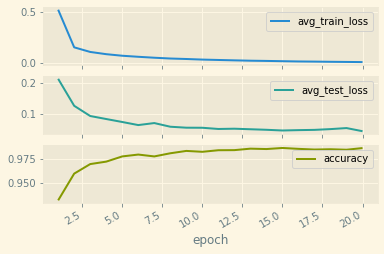

In [78]:
import pandas as pd
perf_report = pd.DataFrame(perf_history)
perf_report['accuracy'] = perf_report.test_correct_items / perf_report.test_items
plt.style.use('Solarize_Light2')
perf_report[['epoch','avg_train_loss', 'avg_test_loss', 'accuracy']].plot(
    x='epoch', subplots=True)
